# All 19 Sites!

/tmp/ipykernel_104845/2805477851.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})


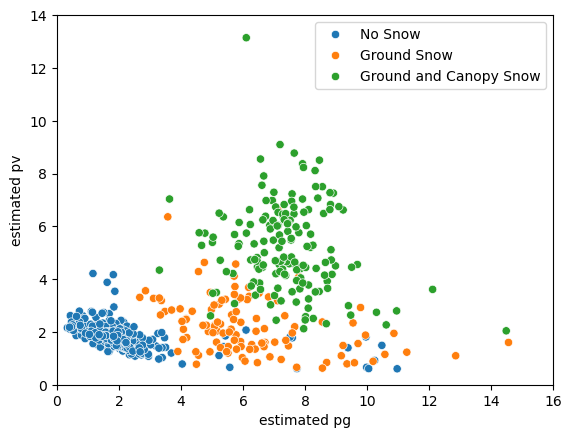

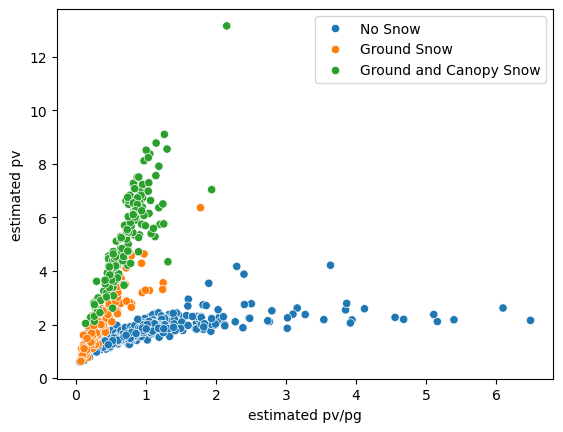

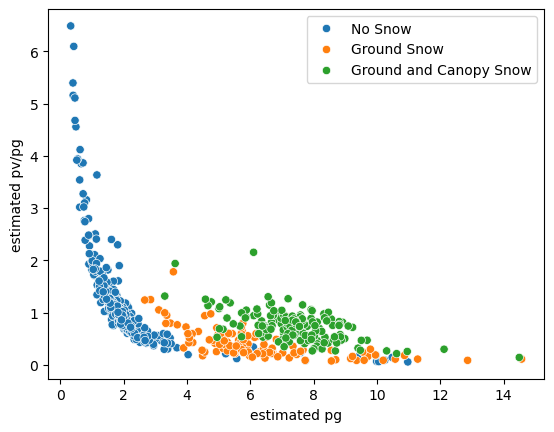

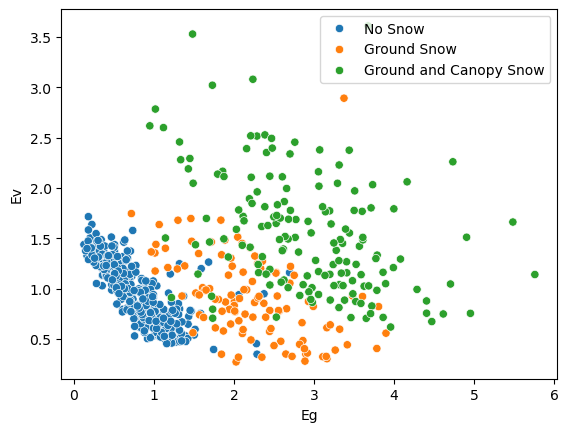

644


,camera,date,lat,lon,pvpg,pv,pg,Eg,Ev,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions
892,old_jack_pine,07/05/2019,53.929814,-104.730241,0.066127,0.660441,9.987482,2.279784,0.453795,22.500000,1.923399,0.05,0.0,0.0,4.0,2.000000,1.546578,1.546578,0.0,No Snow
894,old_jack_pine,07/05/2019,53.947832,-104.730241,0.078967,0.611125,7.738981,1.745712,0.396391,24.086957,1.590534,0.05,0.0,0.0,4.0,2.000000,1.438265,1.438265,0.0,No Snow
902,old_jack_pine,09/10/2023,53.911795,-104.684352,0.055025,0.603731,10.971891,1.278363,0.470724,29.561404,99.058438,0.00,0.0,1.0,23.0,0.000000,1.889532,1.889532,0.0,No Snow
911,old_jack_pine,09/10/2023,53.938823,-104.684352,0.211688,1.106129,5.225269,0.606980,0.769211,27.581818,112.397816,0.00,0.0,1.0,23.0,0.000000,1.548690,1.548690,0.0,No Snow
925,old_jack_pine,10/07/2023,53.920805,-104.714944,0.089847,0.920523,10.245510,1.308498,0.743943,24.361702,2.633845,0.00,0.0,0.0,21.0,0.000000,1.380555,1.380555,0.0,No Snow
1043,old_jack_pine,29/04/2023,53.902786,-104.638463,0.060719,0.610434,10.053371,2.287431,0.349490,27.641509,100.915144,0.00,0.0,1.0,20.0,0.000000,2.162172,2.162172,0.0,No Snow
1827,underc,08/11/2020,46.229395,-89.491715,0.268727,1.443093,5.370108,2.059096,0.939247,18.657143,5.393097,0.00,0.0,0.0,8.0,0.000000,1.661069,1.661069,0.0,No Snow
1830,underc,08/11/2020,46.256423,-89.491715,0.149024,1.398704,9.385768,2.374564,0.949205,21.250000,5.377418,0.00,0.0,0.0,8.0,0.000000,1.635559,1.635559,0.0,No Snow
2104,willowcreek,05/09/2020,45.801495,-90.046791,0.142284,1.490951,10.478689,1.204456,1.145723,27.264151,3.938785,0.00,0.0,0.0,7.0,0.000000,1.640595,1.640595,0.0,No Snow
2106,willowcreek,05/09/2020,45.819514,-90.046791,0.181738,1.811201,9.966001,0.775022,1.230793,33.000000,3.568269,0.00,0.0,0.0,7.0,0.000000,1.912085,1.912085,0.0,No Snow


In [26]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_outlier22_th3_1km_noprior_ta.pkl')
# print(df.columns)
mask = df['beam'] == 3
df.loc[mask, ['pv','pg','Ev','Eg']] /= 0.85

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg': 'mean',
    'Ev': 'mean',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))
    # &(df_grouped['pvpg']>.5)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.8)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.5)&(df_grouped['pv']>2)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<.5)&((df_grouped['FSC'] < .5)|(df_grouped['TreeSnow'] > 0))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)

    &(df_grouped['pv_ratio_mean'] >= 1.3)

    # &(df_grouped['data_quantity'] >= 18)]
    &((df_grouped['layer_flag'] <= .7)|(df_grouped['msw_flag'] < 1))&(df_grouped['data_quantity'] >= 18)]
    # &(df_grouped['layer_flag'] <= .8)&(df_grouped['data_quantity'] > 10)]

data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.round(x))

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
plt.xlim(0,16)
plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pvpg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pv/pg')
plt.ylabel('estimated pv')
# plt.xlim(0,3)
# plt.ylim(0,12)
# plt.plot([0.29,0.29],[0,1.32],'r--')
# plt.plot([0.5,0.5],[1.53,7],'r--')
# plt.plot([0.3,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pvpg', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv/pg')
# plt.xlim(0,20)
# plt.ylim(0,20)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='Eg', y='Ev', hue='Conditions')#, size='data_quantity')
plt.xlabel('Eg')
plt.ylabel('Ev')
# plt.xlim(0,20)
# plt.ylim(0,20)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

print(len(data))
data[(data['pg']>4.5)&(data['JointSnow']==0)]#.sort_values('snr')

In [23]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Assuming your dataframe is called df
# features = ['pvpg', 'pv', 'pg', 'snr', 'pv_ratio_mean', 'pv_ratio_max']
features = ['pv', 'pg', 'pvpg','Ev','Eg']
target = 'JointSnowBinary'

data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)

X = data[features]
y = data[target]

# Optional: standardize the features (helps logistic regression perform better)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression on all data
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_scaled, y)

# Predict on the same data (since you said to use all data)
y_pred = model.predict(X_scaled)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Get boolean mask of incorrect predictions
incorrect_mask = y != y_pred

# Optionally convert y to numpy array if needed
# y = y.to_numpy()

# Get the misclassified rows from the original dataframe
misclassified = data[incorrect_mask]

# Add true and predicted labels to the misclassified DataFrame for inspection
misclassified = misclassified.copy()
misclassified['TrueLabel'] = y[incorrect_mask]
misclassified['PredictedLabel'] = y_pred[incorrect_mask]

# Show the result
misclassified

Confusion Matrix:
[[366   7]
 [  9 262]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       373
           1       0.97      0.97      0.97       271

    accuracy                           0.98       644
   macro avg       0.97      0.97      0.97       644
weighted avg       0.98      0.98      0.98       644



/tmp/ipykernel_104845/4104301870.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


,camera,date,lat,lon,pvpg,pv,pg,Eg,Ev,data_quantity,...,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions,JointSnowBinary,TrueLabel,PredictedLabel
655,lacclair,03/04/2024,46.938586,-71.676199,0.515285,2.100746,4.076860,1.015542,1.174903,21.190476,...,0.738095,22.0,0.000000,1.866963,1.866963,1.0,Ground Snow,1,1,0
657,lacclair,03/04/2024,46.956605,-71.715793,0.792266,2.642871,3.335838,0.966985,1.364953,22.714286,...,1.000000,22.0,0.000000,1.716254,1.716254,1.0,Ground Snow,1,1,0
863,old_jack_pine,01/11/2020,53.884768,-104.638463,0.085513,0.661161,7.731655,2.054830,0.319721,18.888889,...,0.000000,12.0,1.000000,2.395645,2.395645,1.0,Ground Snow,1,1,0
892,old_jack_pine,07/05/2019,53.929814,-104.730241,0.066127,0.660441,9.987482,2.279784,0.453795,22.500000,...,0.000000,4.0,2.000000,1.546578,1.546578,0.0,No Snow,0,0,1
1043,old_jack_pine,29/04/2023,53.902786,-104.638463,0.060719,0.610434,10.053371,2.287431,0.349490,27.641509,...,1.000000,20.0,0.000000,2.162172,2.162172,0.0,No Snow,0,0,1
1495,sodankyla_full,19/04/2022,67.366338,26.669262,0.153807,1.056312,6.867796,1.843648,0.349299,20.714286,...,0.000000,24.0,0.000000,2.511084,2.511084,1.0,Ground Snow,1,1,0
1827,underc,08/11/2020,46.229395,-89.491715,0.268727,1.443093,5.370108,2.059096,0.939247,18.657143,...,0.000000,8.0,0.000000,1.661069,1.661069,0.0,No Snow,0,0,1
1830,underc,08/11/2020,46.256423,-89.491715,0.149024,1.398704,9.385768,2.374564,0.949205,21.250000,...,0.000000,8.0,0.000000,1.635559,1.635559,0.0,No Snow,0,0,1
2170,willowcreek,15/06/2019,45.774468,-90.111409,0.339627,2.070656,6.096850,1.590906,1.199030,28.719298,...,0.000000,3.0,0.456140,1.703342,1.703342,0.0,No Snow,0,0,1
2186,willowcreek,15/06/2019,45.828523,-90.059714,0.240188,1.805596,7.517420,1.683115,1.263874,23.200000,...,0.000000,3.0,0.000000,1.676572,1.676572,0.0,No Snow,0,0,1


In [8]:
print(model.coef_, model.intercept_)

[[ 2.61093682  0.53352439 -2.16549232]] [-0.0124854]


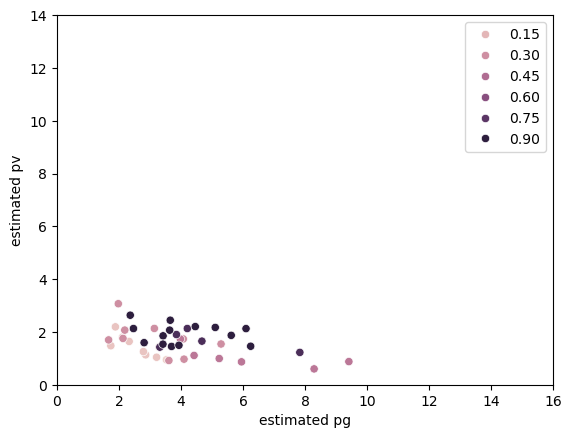

,camera,date,lat,lon,pvpg,pv,pg,Eg,Ev,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow
31,bartlett,07/04/2020,44.060095,-71.281831,0.429342,1.423939,3.316565,0.791667,0.868421,25.980392,96.257014,0.80,0.0,1.000000,4.0,0.000000,1.587590,1.587590,0.80
34,bartlett,07/04/2020,44.069105,-71.281831,0.156321,1.224406,7.832615,0.968870,0.941126,21.761905,96.275983,0.80,0.0,1.000000,4.0,0.000000,1.918446,1.918446,0.80
37,bartlett,07/04/2020,44.078114,-71.319444,0.353284,1.651068,4.673483,1.213889,0.885621,20.050000,86.155904,0.80,0.0,1.000000,4.0,0.000000,1.767123,1.767123,0.80
94,delta_junction,02/05/2021,63.867586,-145.761632,0.236433,0.968535,4.096451,1.512821,0.461538,24.021277,0.731000,0.30,0.0,0.000000,16.0,0.000000,1.696083,1.696083,0.30
100,delta_junction,02/05/2021,63.894614,-145.782096,0.254249,0.917440,3.608428,1.656672,0.346875,20.450000,0.593018,0.30,0.0,0.075000,16.0,0.000000,1.533204,1.533204,0.30
109,delta_junction,03/05/2020,63.876595,-145.802560,1.552078,3.068350,1.976930,0.730256,1.275000,18.470588,0.236758,0.30,0.0,0.000000,8.0,0.000000,2.170438,2.170438,0.30
111,delta_junction,03/05/2020,63.885605,-145.802560,0.679022,2.131826,3.139554,1.075976,1.246212,20.000000,0.259384,0.30,0.0,0.000000,8.0,0.000000,1.574840,1.574840,0.30
114,delta_junction,03/05/2020,63.894614,-145.802560,0.291618,1.542891,5.290789,1.487179,1.025000,22.612903,0.278882,0.30,0.0,0.000000,8.0,0.000000,1.659916,1.659916,0.30
194,delta_junction,26/04/2024,63.876595,-145.761632,0.824436,1.753913,2.127408,1.447368,0.625000,27.914286,0.299608,0.30,0.0,0.000000,32.0,0.000000,1.414791,1.414791,0.30
241,delta_junction,30/04/2022,63.867586,-145.782096,0.392791,1.451084,3.694289,1.620690,0.388889,28.929825,104.108755,0.90,0.0,0.000000,19.0,0.000000,1.860202,1.860202,0.90


In [25]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_outlier22_th3_1km_noprior_ta.pkl')
# print(df.columns)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg': 'median',
    'Ev': 'median',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] > 0.05)&(df_grouped['FSC'] < 0.95))
    # &(df_grouped['pvpg']>.5)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.8)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.5)&(df_grouped['pv']>2)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<.5)&((df_grouped['FSC'] < .5)|(df_grouped['TreeSnow'] > 0))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)

    &(df_grouped['pv_ratio_mean'] >= 1.3)

    # &(df_grouped['data_quantity'] >= 18)]
    &((df_grouped['layer_flag'] <= .7)|(df_grouped['msw_flag'] < 1))&(df_grouped['data_quantity'] >= 18)]
    # &(df_grouped['layer_flag'] <= .8)&(df_grouped['data_quantity'] > 10)]

plt.figure()
sns.scatterplot(data = data.sort_values('FSC'), x='pg', y='pv', hue='FSC')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
plt.xlim(0,16)
plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

data